In [21]:
import numpy as np
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import matplotlib.pyplot as plt
from ts_limit.grid import Grid
from gammaALPs.base.transfer import EminGeV, EmaxGeV

In [22]:
grid = Grid()

In [23]:
log10MeV = np.loadtxt('../grid_survival_prob/energy_bins.dat')
EGeV = np.power(10, log10MeV - 3)

In [24]:
def gammaalps_prob(g, m):
    alp = ALP(m,g)
    ngc1275 = Source(z=0., ra='03h19m48.1s', dec='+41d30m42s')
    global EGeV
    pin = np.diag((1.,1.,0.)) * 0.5
    ml = ModuleList(alp, ngc1275, pin = pin, EGeV = EGeV)
    ml.add_propagation("ICMGaussTurb",
                      0, # position of module counted from the source.
                      nsim=10, # number of random B-field realizations
                      B0=10.,  # rms of B field
                      n0=39.,  # normalization of electron density
                      n2=4.05, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                      r_abell=500., # extension of the cluster
                      r_core=80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                      r_core2=280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                      beta=1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                      beta2=0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                      eta=0.5, # scaling of B-field with electron denstiy
                      kL=0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012
                      kH=9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                      q=-2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                      seed=None # random seed for reproducability, set to None for random seed.
                     )
    px, py, pa = ml.run()
    psurv = px + py
    B = ml.modules["ICMGaussTurb"].Bn
    psi = ml.modules["ICMGaussTurb"].psin
    n_el = ml.modules["ICMGaussTurb"].nel * 1e-3
    r = ml.modules["ICMGaussTurb"].r  # kpc
    result_dic = {'p': psurv, 'B_T': B, 'psi': psi, 'nel': n_el, 'r': r}
    return result_dic

def array_prob(g, m, res_dic):
    B = res_dic['B_T']
    psi = res_dic['psi']
    n_el = res_dic['nel']
    r = res_dic['r']
    dL = np.full(r.shape, r[1] - r[0])
    #dL[0] = (r[1] - r[0])/2
    #dL[-1] = dL[0]
    pin = np.diag((1., 1., 0)) * 0.5
    alp = ALP(m,g)
    ngc1275 = Source(z=0., ra='03h19m48.1s', dec='+41d30m42s')
    global EGeV 
    ml_array = ModuleList(alp, ngc1275, pin = pin, EGeV = EGeV)
    ml_array.add_propagation("Array", 0, Btrans=B, psi=psi, nel=n_el, dL=dL)
    px_man, py_man, pa_man = ml_array.run()
    psurv = px_man + py_man
    res = {'p':psurv}
    return  res

In [25]:
results = np.zeros((900))
indices = np.arange(0, 900)
for i in indices:
    print(i)
    gm = grid.get_gm(i)
    g = gm[0]
    m = gm[1]
    res_icm = gammaalps_prob(g, m)
    res_array = array_prob(g, m, res_icm)
    p_icm = res_icm['p']
    p_arr = res_array['p']
    rel_dev = (p_arr - p_icm) / p_icm
    maximum = np.max(rel_dev)
    results[i] = maximum

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [26]:
np.savetxt('rel_dev_results.dat', results)

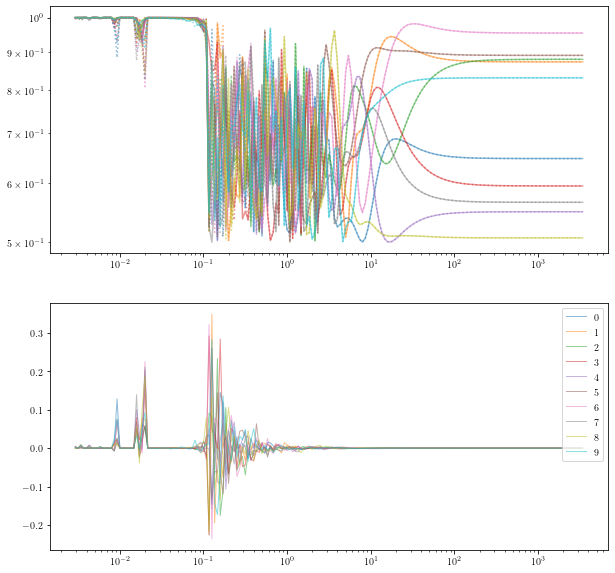

In [7]:
psurv_man = res_array['p']
psurv_ga = res_icm['p']
fig = plt.figure(111, figsize=(10, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
for c, v in enumerate(psurv_man):
    p = ax1.plot(EGeV, psurv_man[c], alpha=0.5)
    ax1.plot(EGeV, psurv_ga[c], c=p[-1].get_color(), alpha=0.5, ls=':') 
    ax2.plot(EGeV, (v - psurv_ga[c]) / psurv_ga[c], alpha=0.5, lw=1, label=f'{c}')
ax2.set_xscale('log')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.legend(loc='upper right')
#ax2.set_title(r'$g_{a\gamma\gamma} = \SI{10e-11}{\per\giga\electronvolt}, m_a = \SI{30}{\nano\electronvolt}$')
#fig.savefig('ICMGaussTurb.png')

In [46]:
res_icm['r'][1] - res_icm['r'][0]

0.1111111111111111

In [27]:
results

array([8.83917047e-02, 3.53462059e-02, 7.08309787e-02, 5.56683690e-02,
       6.41290894e-02, 6.18773023e-02, 7.47237727e-02, 7.48292599e-02,
       7.28260422e-02, 4.43651192e-02, 2.73026723e-02, 2.16912917e-02,
       1.12993507e-02, 1.96275775e-02, 1.23706031e-02, 6.09138305e-03,
       4.47224010e-03, 3.95644519e-03, 1.27292129e-03, 1.00562597e-03,
       5.41130847e-04, 3.80447768e-04, 1.28090264e-04, 1.01958218e-04,
       9.49198718e-05, 1.22571176e-04, 3.82427940e-05, 1.23936096e-05,
       7.87574588e-06, 7.34679370e-06, 1.05554432e-01, 9.05509090e-02,
       1.04741087e-01, 9.29259840e-02, 1.16314475e-01, 1.02231113e-01,
       9.30845832e-02, 7.53723247e-02, 7.32934782e-02, 4.32617564e-02,
       2.80039079e-02, 2.53593436e-02, 2.13825204e-02, 3.47278546e-02,
       8.53948422e-03, 5.95138669e-03, 8.95584290e-03, 2.46362389e-03,
       1.99813940e-03, 1.14435563e-03, 1.17065498e-03, 7.14542658e-04,
       2.00972416e-04, 5.77690717e-04, 8.87185851e-05, 2.21443363e-04,
      